In [1]:
## Importing packages

library(tidyverse) # metapackage with lots of helpful functions
library(png) # package that can be used to read png image files in a simple format
library(caret)
library(e1071)

## Reading in files

# You can access files the "../input/" directory.
# You can see the files by running  

list.files(path = "../input/")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress




[1] "facial-expressions-bda-2021"

In [2]:
# Show the availabe directories
dirs = dir("../input", pattern="[^g]$", recursive=TRUE, include.dirs = TRUE, full.names = TRUE)
dirs

[1] "../input/facial-expressions-bda-2021"                     
[2] "../input/facial-expressions-bda-2021/ckplus"              
[3] "../input/facial-expressions-bda-2021/ckplus/test"         
[4] "../input/facial-expressions-bda-2021/ckplus/train"        
[5] "../input/facial-expressions-bda-2021/ckplus/train/anger"  
[6] "../input/facial-expressions-bda-2021/ckplus/train/disgust"
[7] "../input/facial-expressions-bda-2021/ckplus/train/happy"  
[8] "../input/facial-expressions-bda-2021/ckplus/train/sadness"

In [3]:
# Get all image files: file names ending ".png" 
anger   = dir(grep("anger",   dirs, value = TRUE), pattern = "png$", full.names = TRUE)
disgust = dir(grep("disgust", dirs, value = TRUE), pattern = "png$", full.names = TRUE)
happy   = dir(grep("happy",   dirs, value = TRUE), pattern = "png$", full.names = TRUE)
sad     = dir(grep("sad",     dirs, value = TRUE), pattern = "png$", full.names = TRUE)
test_im = dir(grep("test",    dirs, value = TRUE), pattern = "png$", full.names = TRUE)

str(anger)
str(disgust)
str(happy)
str(sad)
str(test_im)

 chr [1:570] "../input/facial-expressions-bda-2021/ckplus/train/anger/S010_004_00000018a.png" ...
 chr [1:744] "../input/facial-expressions-bda-2021/ckplus/train/disgust/S005_001_00000009a.png" ...
 chr [1:870] "../input/facial-expressions-bda-2021/ckplus/train/happy/S010_006_00000013a.png" ...
 chr [1:354] "../input/facial-expressions-bda-2021/ckplus/train/sadness/S011_002_00000020a.png" ...
 chr [1:1080] "../input/facial-expressions-bda-2021/ckplus/test/S010_004_00000017a.png" ...


The pictures (video stills) show faces that were captured while more or less spontaneously expressing an emotion. Some of the images are repeated, but then shifted, rotated, or both. Not all are easy to classify:

In [4]:
ok = file.copy(  happy[60], "happy.png", overwrite = TRUE)
ok = file.copy(    sad[61],   "sad.png", overwrite = TRUE)
ok = file.copy(  anger[61], "anger.png", overwrite = TRUE)
ok = file.copy(disgust[61], "disgust.png", overwrite = TRUE)
IRdisplay::display_html('<img src="happy.png" width="200" style="float:left" /><img src="sad.png" width="200" style="float:left" /><img src="anger.png" width="200" style="float:left" /><img src="disgust.png" width="200" style="float:left" />')

Clearly the first is a happy face, but is the second a sad face, an angry face, or both?

# Data considerations

It's not difficult to find out how the data were collected. This is an important question to answer about any data set you use in a machine learning project because it will determine to what new data your model will generalize.

Answer the 3 most important questions for any ML project:

1. Where do the data come from? (To which population will results generalize?)
2. What are candidate machine learning methods? (models? features?)
3. What is the Bayes' error bound? (Any guestimate from scientific literature or web resources?)





<div style=color:darkblue;background-color:#fafaff;min-height:8em; >


<br>
<em>... Double tap to type your team's answers to all three questions here ...</em>
<br>
<br>
    
<!-- Use Markdown or HTML to format your answer -->
    

</div>

# Bayes bound

To have an idea of a lower bound on the Bayes bound (i.e., the minimum accuracy that should be achievable). The best 'machine' we have at hand to recognize emotion from facial expression in the human brain. How often do human judges get it correct? In a study by Mollahosseini et al. (2018) an estimate for human classification inter-rater agreement was obtained for 11 emotions. For the four included in this data set they are:


| disgust  |  anger  |  happy  |  sad  |
|---------:|--------:|--------:|-------|
|  67.6%   | 62.3%   | 79.6%   | 69.7% |


Keep this in mind when evaluating the performance of the classifiers that you'll train.

As always, it's handy to evaluate how the algorithm does on the training set: If the training set is not classified accurately, how can you expect the test set to do any better. This obvious fact is often overlooked—surprisingly.

# Images in R

We'll demonstrate how to process images in R by importing the one of these.

In [5]:
img = readPNG(happy[4])
glimpse(img)

 num [1:48, 1:48, 1:3] 0.0824 0.0549 0.0353 0.0235 0.0314 ...


As you can see the image is stored as a three dimensional array. Why is this? Color images are represented by mixing 3 colors: red, green, and blue. Different intensities of light in these three base colors, mixed together give rise to any conceivable color. Hence, the image are represented in R consists of a 2D matrix of pixel intesities, one for each of these base colors. Let's visualise this

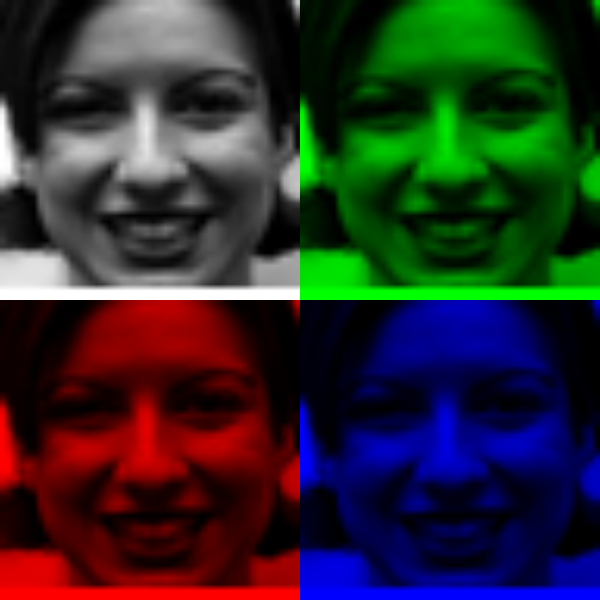

In [6]:
# Define a utility function for painting images
paintImage = function(x, colors=1:3, ..., add=FALSE, axes=FALSE) {if(!add) {opar=par(mar=rep(0,4)); image(array(0,dim(x)[1:2]), ..., col="transparent", axes=axes); par(opar)}; x[,,-colors]=0; usr=par('usr'); rasterImage(x, usr[1], usr[3], usr[2], usr[4], ...)}


options(repr.plot.width = 5, repr.plot.height = 5)

# Visualize the structure of color images
layout(matrix(1:4,2))
paintImage(img)
paintImage(img, colors=1)
paintImage(img, colors=2)
paintImage(img, colors=3)

The different color dimensions are often called *color channels*. Now the pictures in the data set for this competition are gray scale (but nevertheless stored as color images), and so this seems a little superfluous. Let's look at another picture. At the same time we will look at another color channel that the PNG format also supports: the alpha channel, which defines the transparency of a pixel. 

In [7]:
# Download a semi transparent picture of an elephant
download.file("https://i.imgur.com/OKAeTdP.png", destfile = "semitransp.png")
elephant = readPNG("semitransp.png")

str(elephant)

 num [1:859, 1:840, 1:4] 1 1 1 1 1 1 1 1 1 1 ...


Note that the third dimenions of the array has now 4 entries. The last entry is the alpha channel. For each pixel in the picture `elephant[,, 4]` specifies the amount of transparency (0=fully transparent, 1=fully opaque).

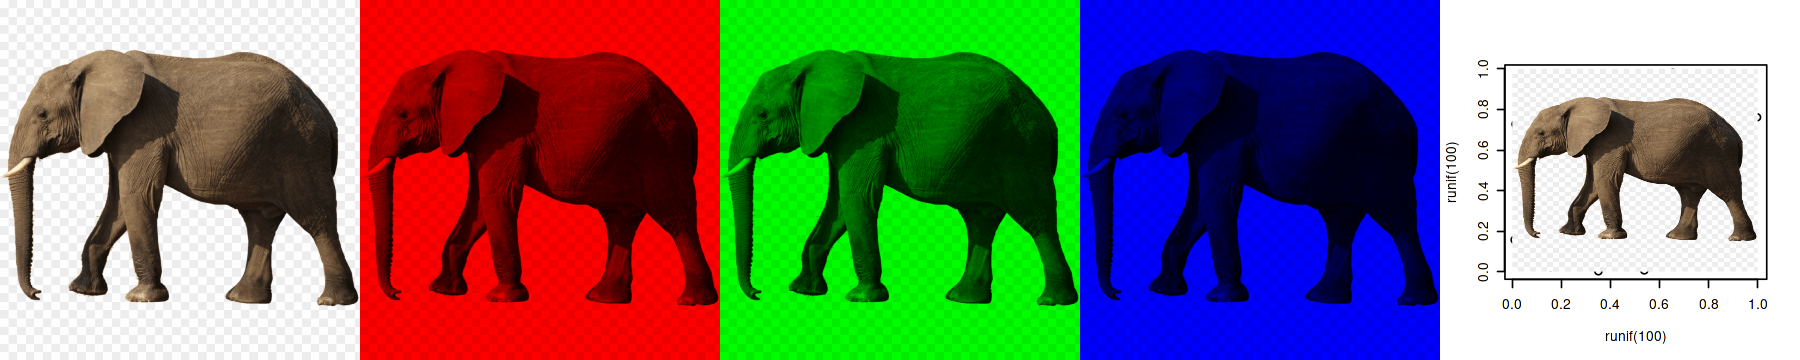

In [8]:

# Draw the elephant itself, and as an overlay over a scatterplot
options(repr.plot.width = 3*5, repr.plot.height = 3)
layout(t(1:5))

# Elephant itself
paintImage(elephant, colors=1:4) 
paintImage(elephant, colors=c(1,4)) 
paintImage(elephant, colors=c(2,4)) 
paintImage(elephant, colors=c(3,4)) 

# Elephant as an overlay
plot(runif(100), runif(100))
rasterImage(elephant, 0, 0, 1, 1)

Now that you have an idea of how images are represented in terms of pixel intensities in three different color channels, you can start thinking about what kind of features you might construct from these pixel values that allow you to classify this images into their respective class.


# Import data

When working with image data, you often have many more Gigabytes of raw data than you have RAM memory available. Therefore, it is often not possible to work with all data "in memory". Resizing images often helps, but may cause loss of information.

The images for this competition are

- gray scale, so we need only one *color channel* 
- are only 48 by 48 pixels

Furthermore there are only 2538 pictures in the training set. Therefore, we are lucky enough to be able to retain all images in RAM, and don't have to do "special stuff" to handle reading in image files while fitting a model.

Reading in images pixelwise is easiest: We simply store each image as a long vector of pixel intensities, row by row. Also we will need a vector that contains the emotion label for each of the images.

In [9]:
# Combine all filenames into a single vector
train_image_files = c(anger, happy, sad, disgust)

# Read in the images as pixel values (discarding color channels)
X = sapply(train_image_files, function(nm) c(readPNG(nm)[,,1])) %>% t() 
y = c(rep("anger", length(anger)), rep("happy", length(happy)), rep("sad", length(sad)), rep("disgust", length(disgust)))

X_test = sapply(test_im, function(nm) c(readPNG(nm)[,,1])) %>% t() 


# Change row and column names of X to something more managable
rownames(X)      = gsub(".+train/", "", rownames(X))
rownames(X_test) = gsub(".+test/",  "", rownames(X_test))

colnames(X) = colnames(X_test) = paste("p",1:ncol(X), sep="")

# Check result (are X, X_test, and y what we expect)
X[1:6,20:23] %>% print
table(y)
                
X_test[1:6,20:23] %>% print

                                    p20        p21        p22        p23
anger/S010_004_00000018a.png 0.58039216 0.60784314 0.70196078 0.85882353
anger/S010_004_00000018b.png 0.02745098 0.02745098 0.04313725 0.07450980
anger/S010_004_00000018c.png 0.03529412 0.03137255 0.02745098 0.01960784
anger/S010_004_00000018d.png 0.03921569 0.03137255 0.03137255 0.02745098
anger/S010_004_00000018e.png 1.00000000 1.00000000 1.00000000 1.00000000
anger/S010_004_00000018f.png 1.00000000 1.00000000 1.00000000 1.00000000


y
  anger disgust   happy     sad 
    570     744     870     354 

                              p20        p21        p22        p23
S010_004_00000017a.png 0.77647059 0.81960784 0.89803922 0.98039216
S010_004_00000017b.png 0.46666667 0.52549020 0.63529412 0.74901961
S010_004_00000017c.png 0.25490196 0.34509804 0.49803922 0.67450980
S010_004_00000017d.png 0.04313725 0.03529412 0.03529412 0.02745098
S010_004_00000017e.png 0.03921569 0.03137255 0.03137255 0.02745098
S010_004_00000017f.png 0.07058824 0.10588235 0.14509804 0.24705882


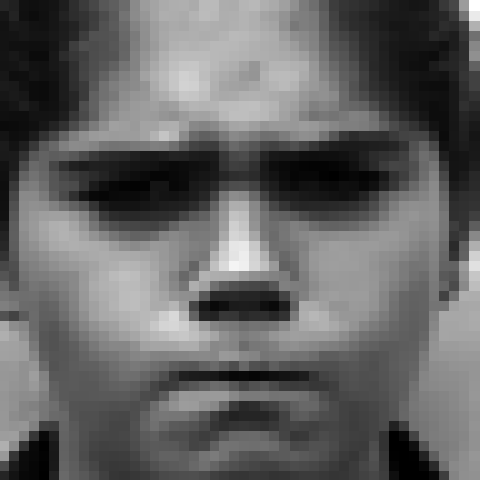

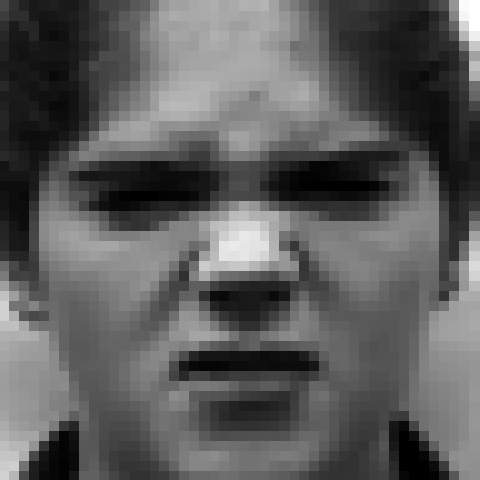

In [10]:
# Visualization utility function
as_image = function(x, nr=sqrt(length(x))) {opar=par(mar=rep(0,4)); on.exit(par(opar)); image(t(matrix(x,nr))[,nr:1], col = gray(0:255/255),axes=F)}


options(repr.plot.width=4, repr.plot.height=4)
as_image(X[13,])
as_image(X_test[13,])

# Histogram features from edges

Histogram features work best on edges. How can you detect edges? To answer that question we have to consider what an edge is: An edge is a rapid change in pixel intensities, so if we compute the difference between two consecutive pixels, and check if it is larger than a certain threshold, we can find the pixels that are at the edge of an abrupt intensity change. In principle this can be done in any possible direction (north, south, west, east, north-west, south-west, etc.), but it turns out that it is enough to do it in only two directions: north and west (or south and east for that matter). These give horizontal and vertical edges respectively. By computing differences in both north and west direction consecutively we filter out pixels that are part of a diagonal edge. 

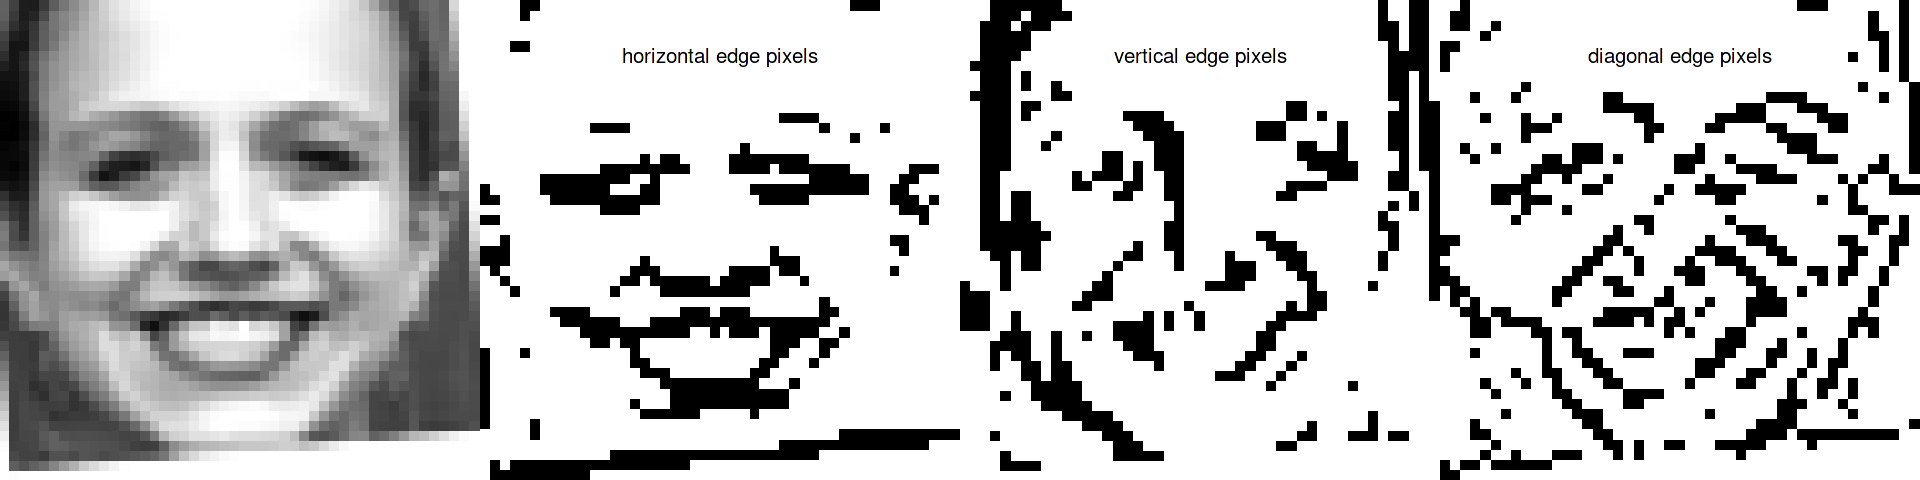

In [11]:
options(repr.plot.width=4*4, repr.plot.height=4)

# Compute edges by differencing neighboring pixels
im = matrix(X[756,],48)
h_edge = im[-1,] - im[-48,] # horizontal
v_edge = im[,-1] - im[,-48] # vertical
d_edge = h_edge[,-1] - h_edge[,-48] # diagonal

# Specify a threshold (hand tuned here on visual result)
threshold = .0625 

layout(t(1:4))
as_image(im)
as_image(h_edge < threshold,   47); mtext("horizontal edge pixels")
as_image(v_edge < threshold,   48); mtext("vertical edge pixels")
as_image(d_edge < threshold/2, 47); mtext("diagonal edge pixels")
#as_image((h_edge[,-1] < 0.1) & (v_edge[-1,] < 0.1), 47); mtext("edge pixels")

In [12]:
edge_features <- function(X) { 
    
    
# Function to compute edge histogram features
    FeaturesH = tibble()
    FeaturesV = tibble()
    FeaturesD = tibble()
    n_edge    = tibble() 
    
# Specify a threshold to determin edge piexl  
    threshold = .0625 
    
    # Create loop for histogram features seen above:
    for (i in 1:nrow(X)) {
        im = matrix(X[i,],48)
        h_edge = im[-1,] - im[-48,] # horizontal
        v_edge = im[,-1] - im[,-48] # vertical
        d_edge = h_edge[,-1] - h_edge[,-48] # diagonal
        
        n_edge[i,1] <- sum(h_edge < threshold) # The toltal number of edge pixls
        n_edge[i,2]<- sum(v_edge < threshold)
        n_edge[i,3] <- sum(d_edge < threshold)
        
        FeaturesH <- bind_rows(FeaturesH, FreySlateFeatures(h_edge < threshold))
        FeaturesV <- bind_rows(FeaturesV, FreySlateFeatures(v_edge < threshold))
        FeaturesD <- bind_rows(FeaturesD, FreySlateFeatures(d_edge < threshold))

    }

    # change colnames of the data frames
    colnames(FeaturesH) <- paste("H",colnames(FeaturesH),sep = "_")
    colnames(FeaturesV) <- paste("V",colnames(FeaturesV),sep = "_")
    colnames(FeaturesD) <- paste("D",colnames(FeaturesD),sep = "_")
    colnames(n_edge)<-c("n_H_edge","n_V_edge","n_D_edge")
    

    Features <- X %>% 
    cbind(FeaturesH) %>% 
    cbind(FeaturesV) %>% 
    cbind(FeaturesD) %>%
    cbind(n_edge) 
    
    return(Features) 
}

You can use the detected edge pixels to compute Frey and Slate type features: Histogram descriptives of the x and y locations of the 'on' pixels in the edge pixel maps.

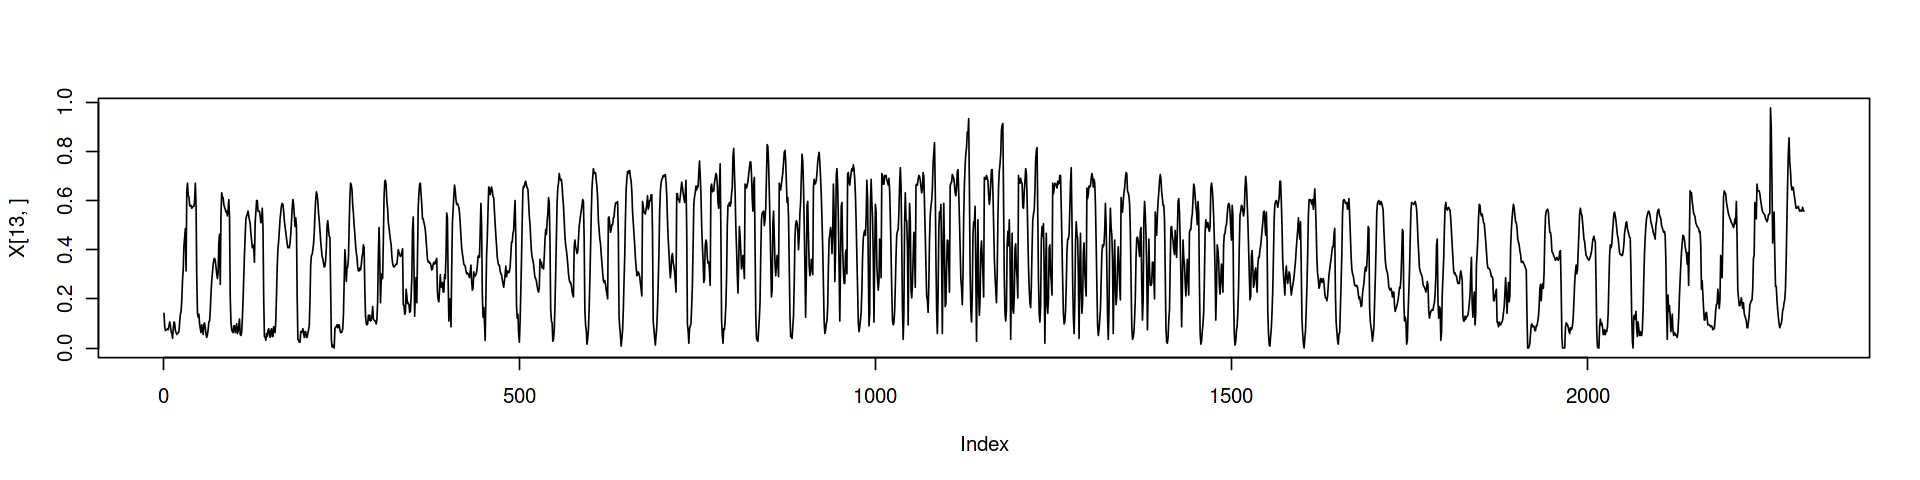

id,p1,p2,p3,p4,p5,p6,p7,p8,p9,⋯,p2295,p2296,p2297,p2298,p2299,p2300,p2301,p2302,p2303,p2304
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
anger/S010_004_00000018a.png,0.06666667,0.04705882,0.03529412,0.01960784,0.03137255,0.05490196,0.05882353,0.07450980,0.06666667,⋯,0.007843137,0.00000000,0.09019608,0.6,0.63921569,0.6392157,0.62745098,0.6156863,0.6156863,0.6117647
anger/S010_004_00000018b.png,0.06274510,0.07058824,0.07058824,0.05490196,0.03921569,0.03921569,0.03921569,0.04313725,0.04313725,⋯,1.000000000,1.00000000,1.00000000,1.0,1.00000000,1.0000000,1.00000000,1.0000000,1.0000000,1.0000000
anger/S010_004_00000018c.png,0.00000000,0.04705882,0.04705882,0.05882353,0.07058824,0.08235294,0.08627451,0.08627451,0.07450980,⋯,1.000000000,1.00000000,1.00000000,1.0,1.00000000,0.9960784,1.00000000,1.0000000,1.0000000,1.0000000
anger/S010_004_00000018d.png,1.00000000,0.94901961,0.02352941,0.04313725,0.02745098,0.02745098,0.03529412,0.02745098,0.03137255,⋯,1.000000000,1.00000000,1.00000000,1.0,1.00000000,1.0000000,1.00000000,1.0000000,1.0000000,0.9882353
anger/S010_004_00000018e.png,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,⋯,0.074509804,0.02352941,0.00000000,0.0,0.02352941,0.4509804,0.62745098,0.6274510,0.6235294,0.6117647
anger/S010_004_00000018f.png,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,⋯,0.094117647,0.07843137,0.03921569,0.0,0.00000000,0.0000000,0.02745098,0.5333333,0.6196078,0.6196078


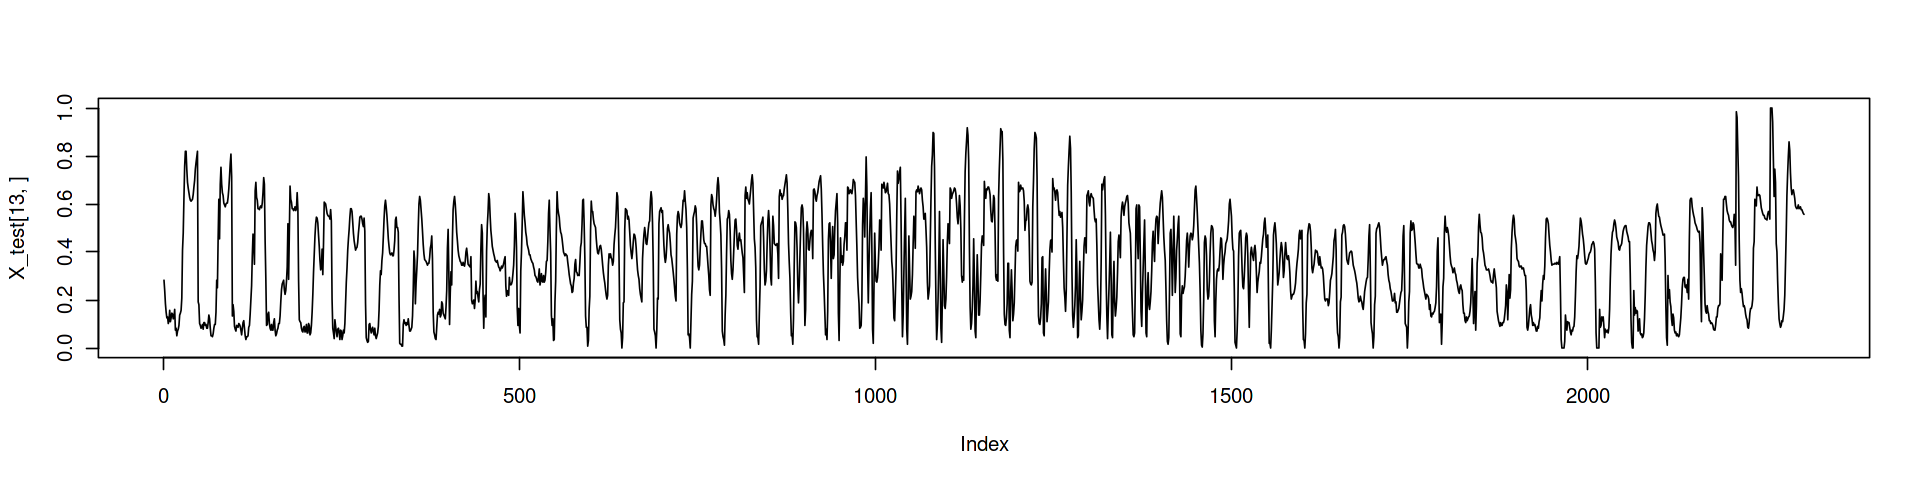

In [13]:


# Plotting the pixel vectors
plot(X[13,], type = "l")
plot(X_test[13,], type = "l")

# Combine X and X_test into a single tibble to compute features
image_data <- as_tibble(X, rownames = "id") %>%
    bind_rows(as_tibble(X_test, rownames = "id")) %>%
    # Reorder columns to have id and outcome at the front
    # (in order to not forget about them)
    select(id, everything())

# Check
head(image_data)



In [14]:
# Transform images data into long format to compute the spectral features as competition 2
images_data_long <- image_data %>%
    pivot_longer(-id, names_to = "px_pos", values_to = "px_value")

# View new data
images_data_long %>% head()

id,px_pos,px_value
<chr>,<chr>,<dbl>
anger/S010_004_00000018a.png,p1,0.06666667
anger/S010_004_00000018a.png,p2,0.04705882
anger/S010_004_00000018a.png,p3,0.03529412
anger/S010_004_00000018a.png,p4,0.01960784
anger/S010_004_00000018a.png,p5,0.03137255
anger/S010_004_00000018a.png,p6,0.05490196


In [15]:
mode <- function(v) {
  uniqv <- unique(v)
  uniqv[which.max(tabulate(match(v, uniqv)))]
}

peak <- function(x) {
  spec <- spectrum(x, plot = FALSE)
  return(spec$freq[which.max(spec$spec)])
}

In [16]:
# function to compute spectral features 
compute_spec_features <- function (image_pixels) {
  image_pixels %>%
    group_by(id) %>%
    summarise(
      # Mean
      mean = mean(px_value),
        
         # Standard Deviation
    sd = sd(px_value),
        
      # Power
      power = mean^2,
        
      # 25% Quartile
      q1_25_px_value = quantile(px_value, .25),

      # 75% Quartile
      q3_75_px_value = quantile(px_value, .75),
        
      # Skewness
      skew = e1071::skewness(px_value),
        
      # Kurtosis
      kurt = e1071::kurtosis(px_value),

      # Mode
      mode = mode(px_value), 
        
      # Spec peak
      peak = peak(px_value),

      # Median
      median = median(px_value), 

      # Variance
      var = var(px_value), 

      # Energy
      energy = sum(px_value^2),        
        
      # Range
      range = max(px_value) - min(px_value), 

      # Full L amplitude 
      amplitude = sum(abs(px_value - mean)),

      # Crest factor 
      crest = max(px_value)/(sqrt(mean^2)), 

      # Median Absolute Deviation (MAD)
      mad = median(abs(px_value - median)),
        
      
    )
}

In [17]:
#functions where not used beacuse they take alot of kaggle memory
entropy  <- function(px_value, nbreaks = nclass.Sturges(x)) {
    image_pixels %>%
    group_by(id) %>%
    r = range(px_value)
    x_binned = findInterval(px_value, seq(r[1], r[2], len= nbreaks))
    h = tabulate(x_binned, nbins = nbreaks) # fast histogram
    p = h/sum(h)
    -sum(p[p>0] * log(p[p>0]))
}

# Set up a function for mode

modeFun <- function(image_pixels, na.rm = FALSE) {
    image_pixels %>%
    group_by(id) %>%
  if(na.rm){
    x = x[!is.na(px_value)]
  }
  ux <- unique(px_value)
  return(ux[which.max(tabulate(match(px_value, ux)))])
}

In [18]:
spec_features <- compute_spec_features(images_data_long)

# Check
head(spec_features)

id,mean,sd,power,q1_25_px_value,q3_75_px_value,skew,kurt,mode,peak,median,var,energy,range,amplitude,crest,mad
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
anger/S010_004_00000018a.png,0.3215448,0.2404281,0.1033911,0.09019608,0.5137255,0.3791546,-0.8222271,0,0.0004340278,0.3058824,0.05780568,371.3395,1,475.6144,3.109987,0.2117647
anger/S010_004_00000018b.png,0.3731516,0.2812963,0.1392421,0.12549020,0.5529412,0.5788584,-0.4151636,1,0.0004340278,0.3470588,0.07912760,503.0446,1,534.4089,2.679876,0.2137255
anger/S010_004_00000018c.png,0.3998434,0.2929819,0.1598748,0.15294118,0.5803922,0.5312902,-0.5815242,1,0.0416666667,0.3725490,0.08583841,566.0373,1,555.8551,2.500979,0.2117647
anger/S010_004_00000018d.png,0.3609154,0.2690661,0.1302599,0.12156863,0.5450980,0.5491426,-0.3756793,1,0.0004340278,0.3411765,0.07239658,466.8482,1,512.4283,2.770733,0.2117647
anger/S010_004_00000018e.png,0.3597086,0.2816508,0.1293903,0.09803922,0.5450980,0.6162241,-0.3859230,1,0.0004340278,0.3372549,0.07932720,480.8058,1,537.7461,2.780028,0.2235294
anger/S010_004_00000018f.png,0.3737371,0.2860984,0.1396794,0.10196078,0.5568627,0.5591942,-0.4878530,1,0.0004340278,0.3529412,0.08185229,510.3271,1,545.1215,2.675678,0.2235294


In [19]:
# Load FreySlateFeatures function 
source("https://bit.ly/32um24j")

FreySlateFeatures(h_edge < threshold)

x.box     y.box     width      high     onpix     x.bar     y.bar     x2bar 
 7.978723  8.138298 14.680851 15.000000 12.657311  7.231798  7.467333  3.620533 
    y2bar     xybar    x2ybar    xy2bar     x.ege     xegvy     y.ege     yegvx 
 3.779328  3.671006  1.796005  1.834935 13.552632 15.855591 20.416667 38.644183

# Final Dataset

In [20]:
X_train <- X %>% 
    edge_features() %>%
    as_tibble( rownames = "id") %>%
    left_join(spec_features, by = "id") %>%
    select(- id)



# Check result
X_train[1:6,2348:2358] %>% print
dim(X_train)

# A tibble: 6 × 11
  D_xy2bar D_x.ege D_xegvy D_y.ege D_yegvx n_H_edge n_V_edge n_D_edge  mean
     <dbl>   <dbl>   <dbl>   <dbl>   <dbl>    <int>    <int>    <int> <dbl>
1     1.76    14.9    16.7    12.7    21.2     1847     1971     2053 0.322
2     1.76    12.5    21.4    11.5    19.0     1845     1902     2054 0.373
3     1.76    11.6    19.1    11.9    19.8     1819     1899     2059 0.400
4     1.76    11.7    15.4    11      17.9     1878     1909     2074 0.361
5     1.76    15.3    16.0    13.1    21.5     1859     1986     2051 0.360
6     1.76    12.0    11.5    11.2    17.5     1867     1997     2086 0.374
# … with 2 more variables: sd <dbl>, power <dbl>


[1] 2538 2371

Note that Frey & Slate features were designed for distinguishing capital characters; not for distinguishing emotions in pictures of human faces. If you want to go this handicraft way of feature extraction you may want to consider chosing different histogram descriptors.

You will notice that not all features computed this way have non-zero variance, and it is generally dificult to predict which features are highly correlated or multi-collinear.

# Near Zero variance 

In [21]:
# Near zero variance
dim(X_train) # before

nzv <- X_train %>% caret::nearZeroVar(names = TRUE)
nzv

X_train <- X_train %>% select(- all_of(nzv))

dim(X_train) # after

[1] 2538 2371

[1] "p1"      "p26"     "p28"     "p29"     "p30"     "p31"     "p44"    
  [8] "p45"     "p46"     "p47"     "p48"     "p76"     "p95"     "p96"    
 [15] "p144"    "p528"    "p576"    "p624"    "p672"    "p720"    "p721"   
 [22] "p768"    "p769"    "p770"    "p816"    "p817"    "p818"    "p864"   
 [29] "p865"    "p866"    "p911"    "p912"    "p913"    "p914"    "p959"   
 [36] "p960"    "p961"    "p962"    "p1007"   "p1008"   "p1009"   "p1010"  
 [43] "p1055"   "p1056"   "p1057"   "p1103"   "p1104"   "p1105"   "p1151"  
 [50] "p1152"   "p1153"   "p1154"   "p1199"   "p1200"   "p1201"   "p1247"  
 [57] "p1248"   "p1249"   "p1250"   "p1295"   "p1296"   "p1297"   "p1298"  
 [64] "p1343"   "p1344"   "p1345"   "p1346"   "p1391"   "p1392"   "p1393"  
 [71] "p1394"   "p1439"   "p1440"   "p1441"   "p1442"   "p1487"   "p1488"  
 [78] "p1489"   "p1490"   "p1535"   "p1536"   "p1537"   "p1538"   "p1583"  
 [85] "p1584"   "p1585"   "p1631"   "p1632"   "p1680"   "p1727"   "p1728"  
 [92] "p1729"   "p1775"   "p1776"   "p1777"   "p1823"   "p1824"   "p1872"  
 [99] "p2208"   "p2209"   "p2231"   "p2240"   "p2254"   "p2255"   "p2256"  
[106] "p2257"   "p2258"   "p2259"   "p2286"   "p2287"   "p2289"   "p2290"  
[113] "p2291"   "p2292"   "p2293"   "p2294"   "p2295"   "p2296"   "p2297"  
[120] "p2298"   "p2299"   "p2300"   "p2301"   "p2302"   "p2303"   "p2304"  
[127] "H_x.box" "H_y.box" "H_width" "H_high"  "V_x.box" "V_y.box" "V_width"
[134] "V_high"  "D_x.box" "D_y.box" "D_width" "D_high"  "range"

[1] 2538 2232

# Training and validation set
The test set is 20% of the training test, so using the test set from the training to test our models. 

In [22]:
# Split data into training set and validation set
df <- data.frame(y, X_train)
train_ind <- sample(nrow(df), 0.8 * nrow(df))#20% of the training data 

# Training set
train_X <- X_train[train_ind,]
train_y <- y[train_ind]
dim(train_X)
length(train_y)

# Validation set
validation_X <- X_train[-train_ind,]
validation_y <- y[-train_ind]
dim(validation_X)
length(validation_y)

[1] 2030 2232

[1] 2030

[1]  508 2232

[1] 508

# Fit a model

To figure out which model provides the best trade off between bias and variance, between accuracy and flexibility, one strategy is to fit both a flexible and a more rigid model and determine from CV error which direction on the flexiblity axis we should go to avoid overtraining.

We'll consider classification trees and random forests here. Random forests are probably the least susceptible to overtraining and is considered one of the best "off the shelf" machine learning algorithms in the sense that they require little expertise in application, and easily perform well without tuning. (This is not to say that tuning should not be considered!) It's your uncle Bob's prefered algorithm so to say.



## Random forests

As an example, here we fit a classification tree, using the pixel based approach.

In [23]:
# Fit a CART using 5-fold cross-validation to tune the 
# complexity parameter

trCntrl = trainControl('cv', 5, allowParallel = TRUE)
fit_rf = train(train_X, 
    train_y, 
    method = 'ranger', 
    trControl = trCntrl, 
    tuneLength = 15,
    tuneGrid = data.frame(mtry=sqrt(ncol(train_X)), 
                                    splitrule = "gini", 
                                    min.node.size = 1),
              )

fit_rf$finalModel$prediction.error

Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”


[1] 0.1059113

In [24]:
# Prediction on validation set
pred_rf = predict(fit_rf, validation_X, type = "raw") %>% as.factor()
confusionMatrix(pred_rf, as.factor(validation_y))


Confusion Matrix and Statistics

          Reference
Prediction anger disgust happy sad
   anger      99       3     0   8
   disgust     9     150     1  11
   happy       0       6   169   0
   sad         3       1     0  48

Overall Statistics
                                          
               Accuracy : 0.9173          
                 95% CI : (0.8899, 0.9398)
    No Information Rate : 0.3346          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8848          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: anger Class: disgust Class: happy Class: sad
Sensitivity                0.8919         0.9375       0.9941    0.71642
Specificity                0.9723         0.9397       0.9822    0.99093
Pos Pred Value             0.9000         0.8772       0.9657    0.92308
Neg Pred Value             0.9698         0.9703  

#  The test dataset

In [25]:


# Add features to test sample dataset
X_test <- X_test %>% 
    edge_features() %>%
   as_tibble(rownames = "id") %>%
    left_join(spec_features, by = "id")

X_test<-column_to_rownames(X_test, var = "id") 

head(X_test)



,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,⋯,kurt,mode,peak,median,var,energy,range,amplitude,crest,mad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S010_004_00000017a.png,0.09411765,0.06666667,0.03921569,0.02352941,0.02352941,0.03921569,0.05490196,0.08235294,0.07450980,0.05882353,⋯,-0.7631589,0,0.0004340278,0.3058824,0.05868278,376.1797,1,477.6706,3.091739,0.2117647
S010_004_00000017b.png,0.05882353,0.07450980,0.07450980,0.05882353,0.04313725,0.04313725,0.04313725,0.04705882,0.05098039,0.05098039,⋯,-0.4970491,1,0.0416666667,0.3509804,0.08492539,534.4830,1,554.3500,2.607387,0.2176471
S010_004_00000017c.png,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,0.07450980,0.03529412,0.03529412,0.03137255,0.02745098,⋯,-0.4193823,1,0.0004340278,0.3450980,0.08219151,504.7238,1,544.5843,2.702621,0.2235294
S010_004_00000017d.png,1.00000000,0.06274510,0.05098039,0.03137255,0.02745098,0.03529412,0.03529412,0.04313725,0.05490196,0.05490196,⋯,-0.4559266,1,0.0004340278,0.3490196,0.08466264,523.5026,1,552.7465,2.648240,0.2196078
S010_004_00000017e.png,1.00000000,0.11764706,0.03137255,0.04705882,0.05882353,0.07058824,0.06666667,0.05098039,0.04313725,0.04313725,⋯,-0.6212742,1,0.0004340278,0.3647059,0.09239843,574.0575,1,577.3154,2.525393,0.2235294
S010_004_00000017f.png,0.91764706,0.01568627,0.05098039,0.03529412,0.03529412,0.03921569,0.03529412,0.03921569,0.04705882,0.05098039,⋯,-0.4399136,0,0.0416666667,0.3392157,0.07040734,458.9923,1,508.9273,2.785973,0.2098039


In [26]:

#running the whole dataframe 
df = data.frame(y, X_train)
# Run the best model again on the whole training set
# Fit a CART using 5-fold cross-validation to tune the 
# complexity parameter
#set.seed(2020) # for repeatability
trCntrl = trainControl('cv', 5, allowParallel = TRUE)

fit_rf = train(X_train, 
    y, 
    method = 'ranger', 
    trControl = trCntrl, 
    tuneLength = 15,
    tuneGrid = data.frame(mtry=sqrt(ncol(df)), 
                                    splitrule = "gini", 
                                    min.node.size = 1),
   )

fit_rf$finalModel$prediction.error

Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”


[1] 0.08904649

In [27]:
data_all <- data.frame(X_train,
                  y = as.factor(y))

fit_svm_full <- e1071::svm(y ~.,data = data_all, kernel = 'radial', cost = 5, scale = TRUE)

# Formatting your submission file

To format your submission file, you can use the following code:

In [28]:
## Make predictions

predtree = predict(fit_svm_full, X_test, type='raw')


## Write to file
tibble(file = rownames(X_test), category = predtree) %>% 
    write_csv(path = "submission.csv")
length(predtree)

## Check result
cat(readLines("submission.csv",n=20), sep="\n")

Warning message:
“The `path` argument of `write_csv()` is deprecated as of readr 1.4.0.
Please use the `file` argument instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


[1] 1080

file,category
S010_004_00000017a.png,anger
S010_004_00000017b.png,anger
S010_004_00000017c.png,disgust
S010_004_00000017d.png,anger
S010_004_00000017e.png,disgust
S010_004_00000017f.png,anger
S011_002_00000022a.png,sad
S011_002_00000022b.png,sad
S011_002_00000022c.png,sad
S011_002_00000022d.png,sad
S011_002_00000022e.png,sad
S011_002_00000022f.png,sad
S011_005_00000018a.png,disgust
S011_005_00000018b.png,disgust
S011_005_00000018c.png,disgust
S011_005_00000018d.png,disgust
S011_005_00000018e.png,disgust
S011_005_00000018f.png,disgust
S011_006_00000013a.png,happy
